<a href="https://colab.research.google.com/github/pachterlab/Clytia_single_cell_2020/blob/master/notebooks/starvation_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pachterlab/Clytia_single_cell_2020/blob/master/notebooks/starvation_Analysis.ipynb)

In [7]:
!date

Sun Jun 14 22:37:05 UTC 2020


In [8]:
#Starvation h5ad data, all nonzero genes included, filtered for 'real cells' from de-multiplexing
!wget https://caltech.box.com/shared/static/3l60szs0e9hgaax4q9dbuehgoo092xww

--2020-06-14 22:47:12--  https://caltech.box.com/shared/static/3l60szs0e9hgaax4q9dbuehgoo092xww
Resolving caltech.box.com (caltech.box.com)... 107.152.29.197
Connecting to caltech.box.com (caltech.box.com)|107.152.29.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/3l60szs0e9hgaax4q9dbuehgoo092xww [following]
--2020-06-14 22:47:13--  https://caltech.box.com/public/static/3l60szs0e9hgaax4q9dbuehgoo092xww
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://caltech.app.box.com/public/static/3l60szs0e9hgaax4q9dbuehgoo092xww [following]
--2020-06-14 22:47:13--  https://caltech.app.box.com/public/static/3l60szs0e9hgaax4q9dbuehgoo092xww
Resolving caltech.app.box.com (caltech.app.box.com)... 107.152.24.201
Connecting to caltech.app.box.com (caltech.app.box.com)|107.152.24.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: h

In [12]:
#CellRanger (Jase) Starvation h5ad data
!wget https://caltech.box.com/shared/static/ts2i8pid7uky28kke4duyl8jwugx8z4h

--2020-06-14 23:52:20--  https://caltech.box.com/shared/static/ts2i8pid7uky28kke4duyl8jwugx8z4h
Resolving caltech.box.com (caltech.box.com)... 107.152.24.197
Connecting to caltech.box.com (caltech.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ts2i8pid7uky28kke4duyl8jwugx8z4h [following]
--2020-06-14 23:52:21--  https://caltech.box.com/public/static/ts2i8pid7uky28kke4duyl8jwugx8z4h
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://caltech.app.box.com/public/static/ts2i8pid7uky28kke4duyl8jwugx8z4h [following]
--2020-06-14 23:52:21--  https://caltech.app.box.com/public/static/ts2i8pid7uky28kke4duyl8jwugx8z4h
Resolving caltech.app.box.com (caltech.app.box.com)... 107.152.29.201
Connecting to caltech.app.box.com (caltech.app.box.com)|107.152.29.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: h

In [9]:
!pip install anndata

     |████████████████████████████████| 122kB 4.8MB/s 


In [10]:
!pip install scanpy

     |████████████████████████████████| 7.2MB 2.7MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 


In [20]:
!pip3 install leidenalg

     |████████████████████████████████| 2.4MB 4.4MB/s 
     |████████████████████████████████| 3.2MB 34.0MB/s 


###**Import Packages** 

In [0]:
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import scipy.sparse

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import (KNeighborsClassifier,NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline
sc.set_figure_params(dpi=125)

import seaborn as sns
sns.set(style="whitegrid")

####**Gene Filtering & Clustering**

In [16]:
#Read in starvation data

#Kallisto bus h5ad file with no gene filtering 
bus_fs_raw = anndata.read("3l60szs0e9hgaax4q9dbuehgoo092xww")
print(bus_fs_raw )

#CellRanger h5ad file with old louvain clustering
cellRanger_fs = anndata.read("ts2i8pid7uky28kke4duyl8jwugx8z4h")
print(cellRanger_fs)

AnnData object with n_obs × n_vars = 13673 × 46716
    obs: 'batch'
AnnData object with n_obs × n_vars = 13673 × 2657
    obs: 'n_counts', 'n_countslog', 'louvain', 'orgID', 'fed', 'starved', 'fed_ord', 'starved_ord', 'new_fed', 'fed_neighbor_score'
    var: 'n_counts', 'n_cells'
    uns: 'fed_ord_colors', 'louvain', 'louvain_colors', 'louvain_sizes', 'neighbors', 'new_fed_colors', 'orgID_colors', 'paga', 'pca', 'rank_genes_groups', 'starved_ord_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


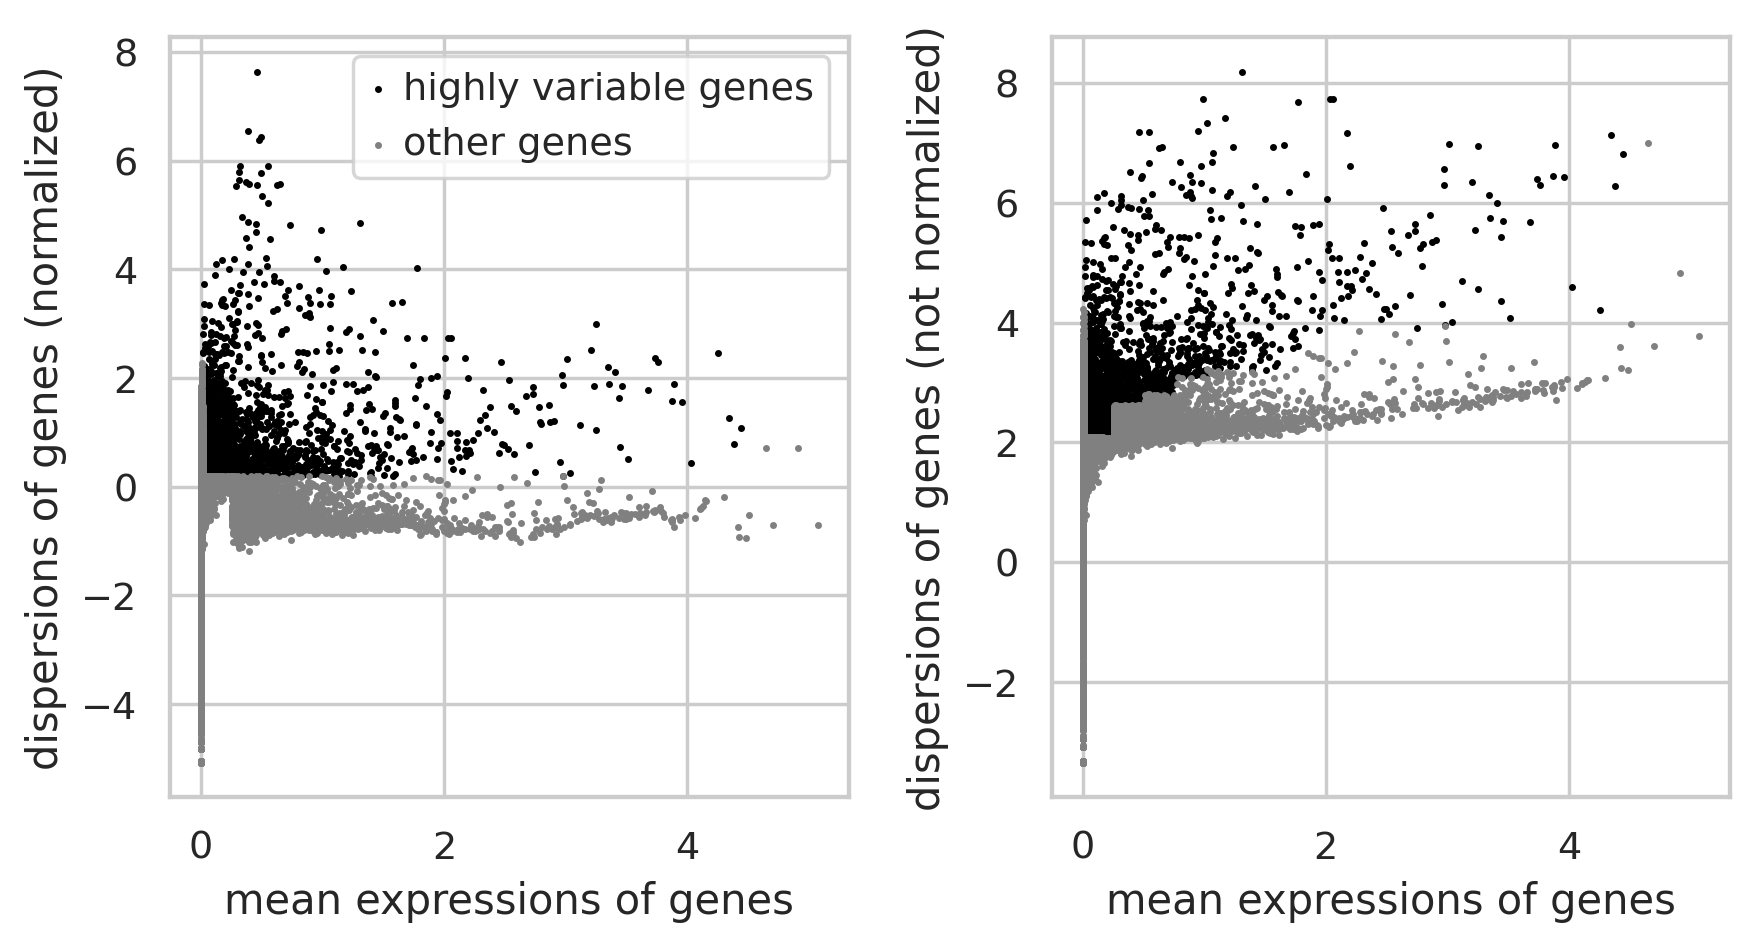

In [17]:
#Find highly variable genes from all nonzero genes
sc.pp.filter_cells(bus_fs_raw, min_counts=1)
sc.pp.filter_genes(bus_fs_raw, min_counts=1)
bus_fs_raw.obs['n_countslog']=np.log10(bus_fs_raw.obs['n_counts'])

bus_fs_raw.raw = sc.pp.log1p(bus_fs_raw, copy=True)
sc.pp.normalize_per_cell(bus_fs_raw, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(
    bus_fs_raw.X, min_mean=0.0125, max_mean=4.5, min_disp=0.2)
sc.pl.filter_genes_dispersion(filter_result)

In [18]:
#Filter genes from anndata
bus_fs_raw = bus_fs_raw[:, filter_result.gene_subset]

print(bus_fs_raw)

View of AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog'
    var: 'n_counts'


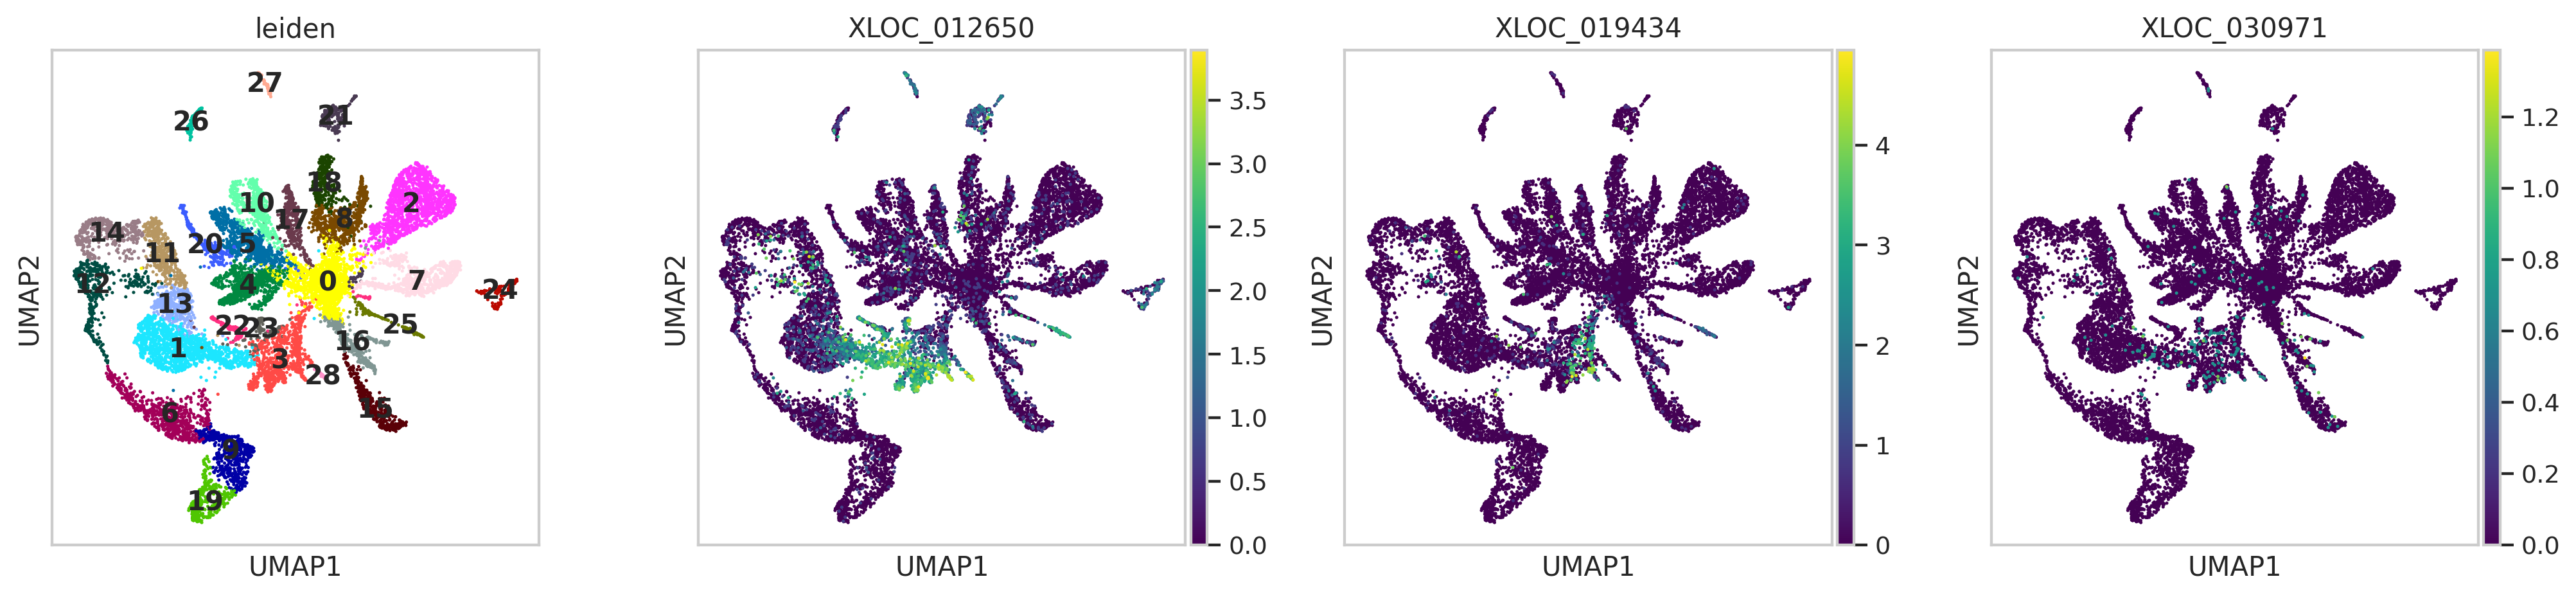

In [21]:
#UMAP embedding and Leiden Clustering
sc.pp.scale(bus_fs_raw, max_value=10) #Only for visualization
sc.tl.pca(bus_fs_raw, n_comps=60)
#sc.pl.pca_variance_ratio(bus_fs_raw, log=True)

sc.pp.neighbors(bus_fs_raw,n_neighbors=40, n_pcs=30) #n_neighbors=5, n_pcs=15
sc.tl.leiden(bus_fs_raw,resolution=1) #Control granularity of clusters
sc.tl.umap(bus_fs_raw)

sc.pl.umap(bus_fs_raw, color=['leiden','XLOC_012650', 'XLOC_019434','XLOC_030971'],legend_loc='on data',color_map='viridis')

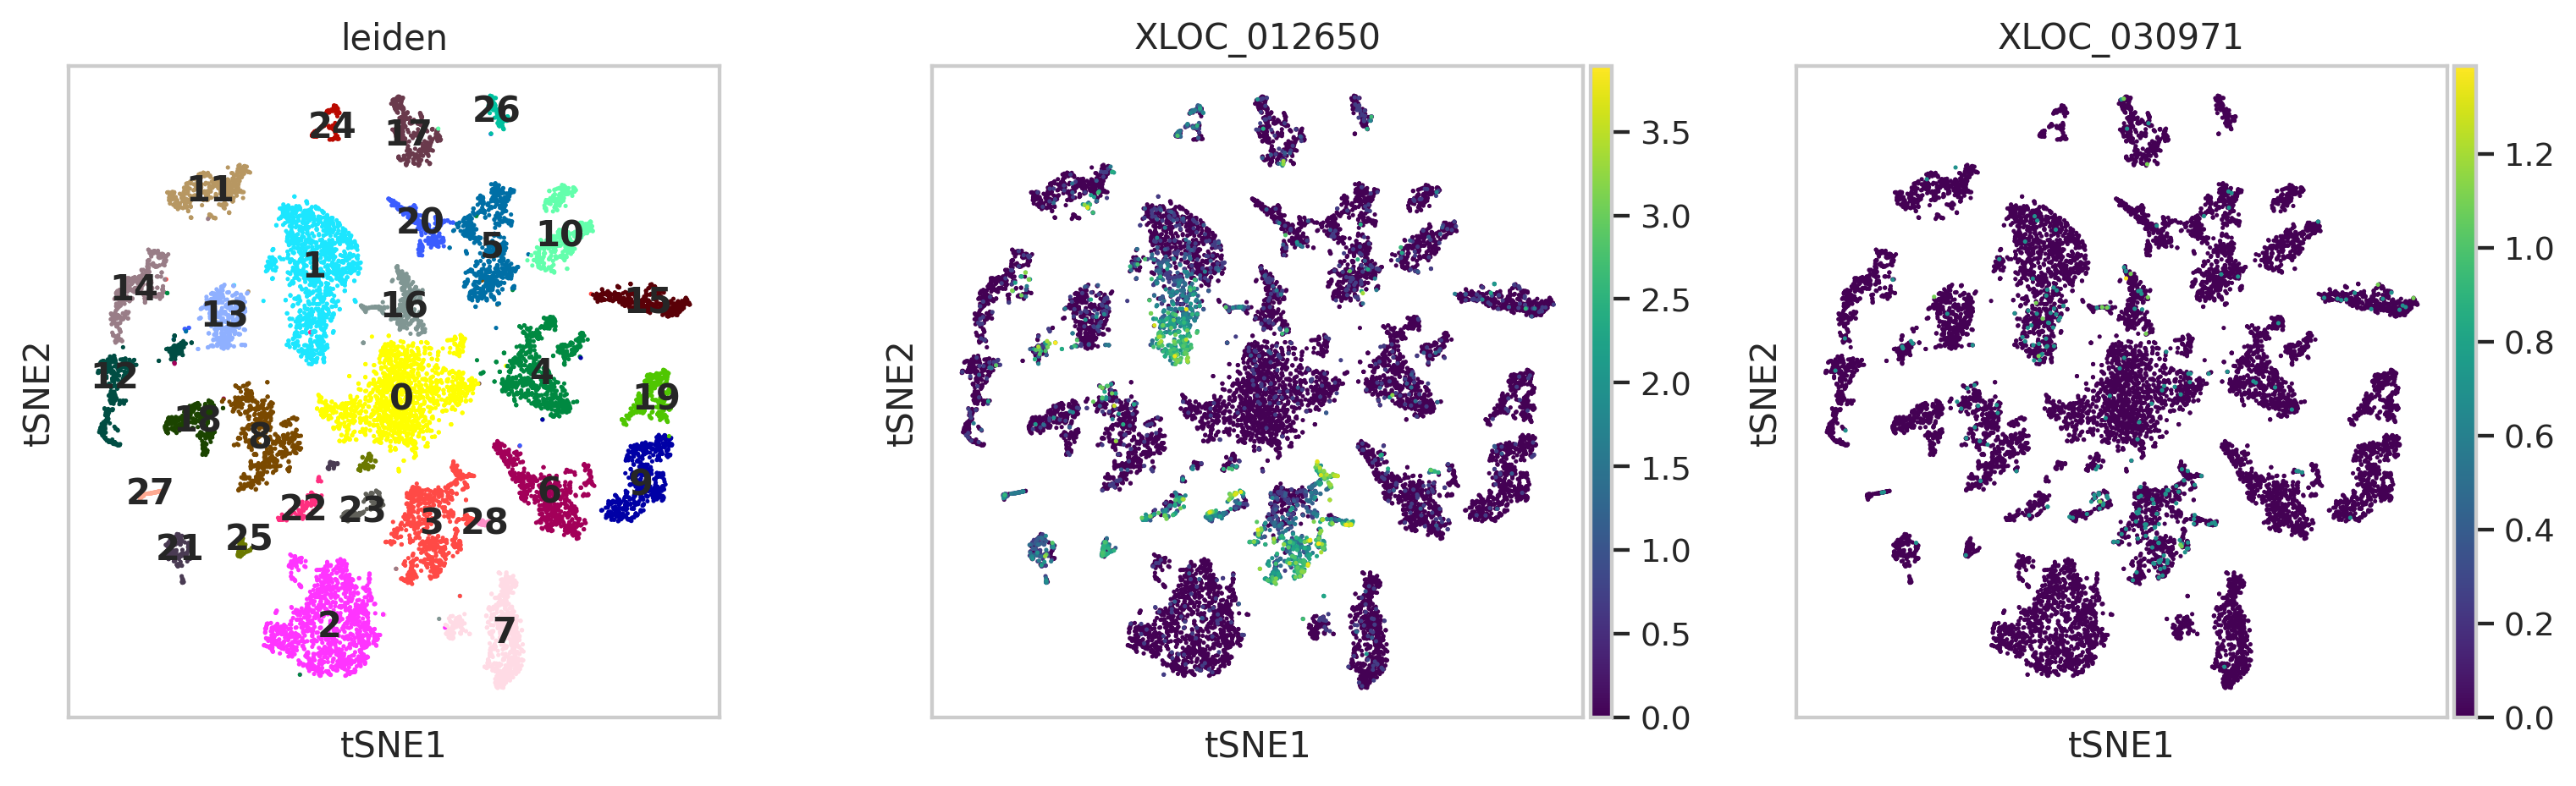

In [22]:
#Supervised TSNE Embedding (with NCA-based Clustering) (just for )
nca = NeighborhoodComponentsAnalysis(n_components=30)
knn = KNeighborsClassifier() 
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
X_nca = nca.fit_transform(bus_fs_raw.X,list(bus_fs_raw.obs['leiden'])) #Superivised labels = Leiden clusters

X_embedded = TSNE(n_components=2).fit_transform(X_nca)
bus_fs_raw.obsm['X_tsne'] = X_embedded
sc.pl.tsne(bus_fs_raw,color=['leiden','XLOC_012650','XLOC_030971'],color_map='viridis',legend_loc='on data')

####**Neighbor Scoring/Similarity**

In [0]:
#Add labels from CellRanger Analysis
bus_fs_raw.obs['orgID'] = cellRanger_fs.obs['orgID']
bus_fs_raw.obs['fed'] = cellRanger_fs.obs['fed']
bus_fs_raw.obs['starved'] = cellRanger_fs.obs['starved']

In [0]:
#Calculate number of neighbors (out of top 15) with same starvation condition
#Input adata object and if score is for fed or starved (True or False)
def neighborScores(adata,conditionBool):
  sc.pp.neighbors(adata,n_neighbors=15)
  neighborDists = adata.uns['neighbors']['distances'].todense()
  counts = []

  for i in range(0,len(adata.obs_names)):
    cellNames = adata.obs_names
      
    #get fed observation for this cell
    cellObs = adata.obs['fed'][cellNames[i]]
      
    #get row for cell
    nonZero = neighborDists[i,:]>0
    l = nonZero.tolist()[0]

    cellRow = neighborDists[i,:]
    cellRow = cellRow[:,l]
      
    #get indices of top15 
    #idx = np.argpartition(cellRow, 15)[0,:15].tolist()[0]

    #get 'fed' observations
    obs = adata.obs['fed'][l]
    #obs = obs[idx]
      
    # count # in 'fed' observations == cell obs
    count = 0
    if cellObs == conditionBool:
      for j in obs:
        if j == conditionBool: #cellObs:
          count += 1
              

    counts += [count]
      
  print(len(counts))

  return counts

13673


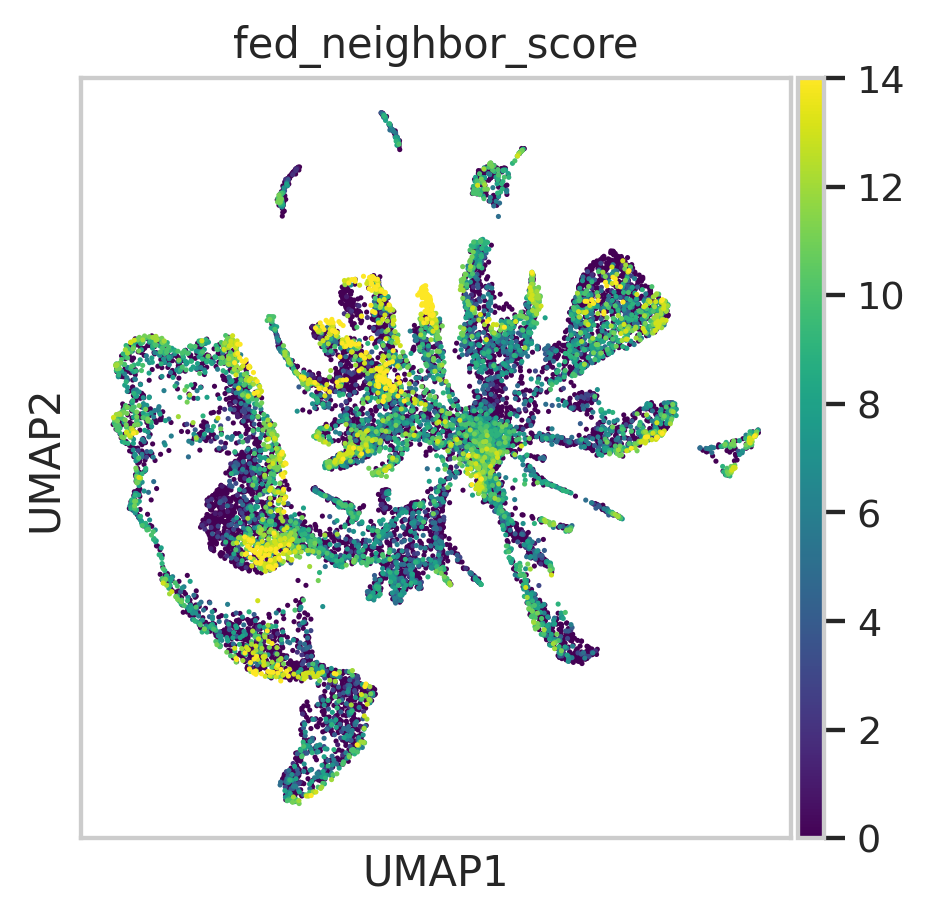

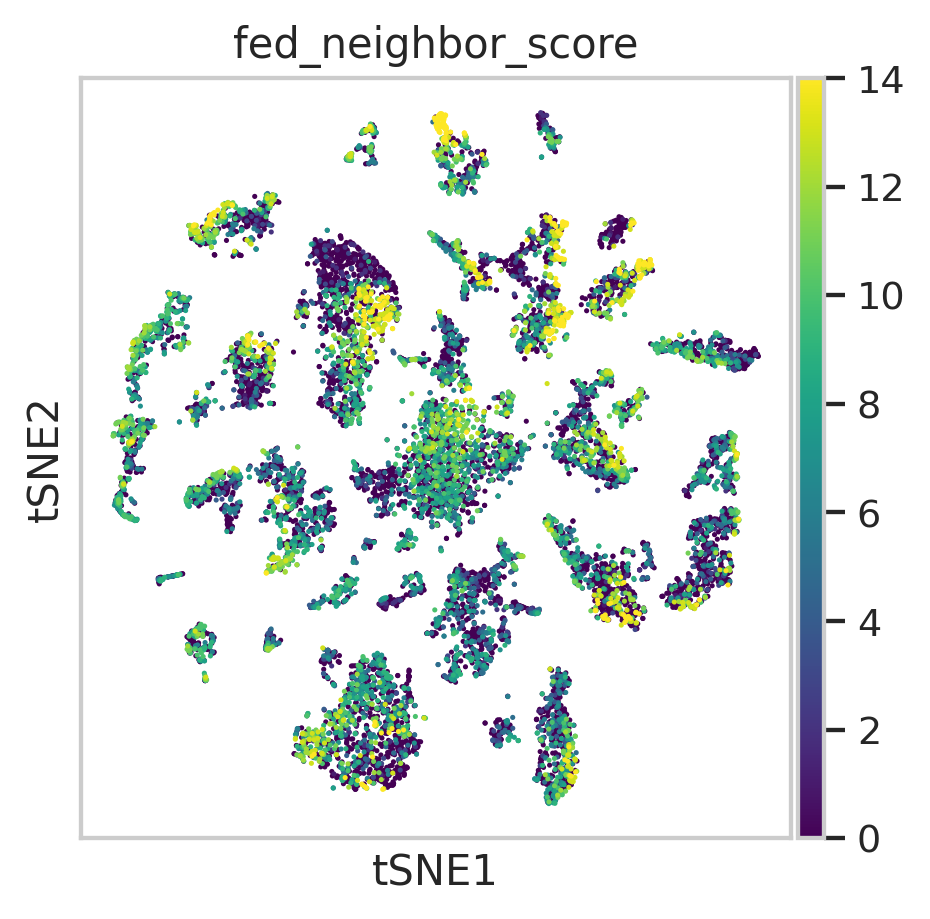

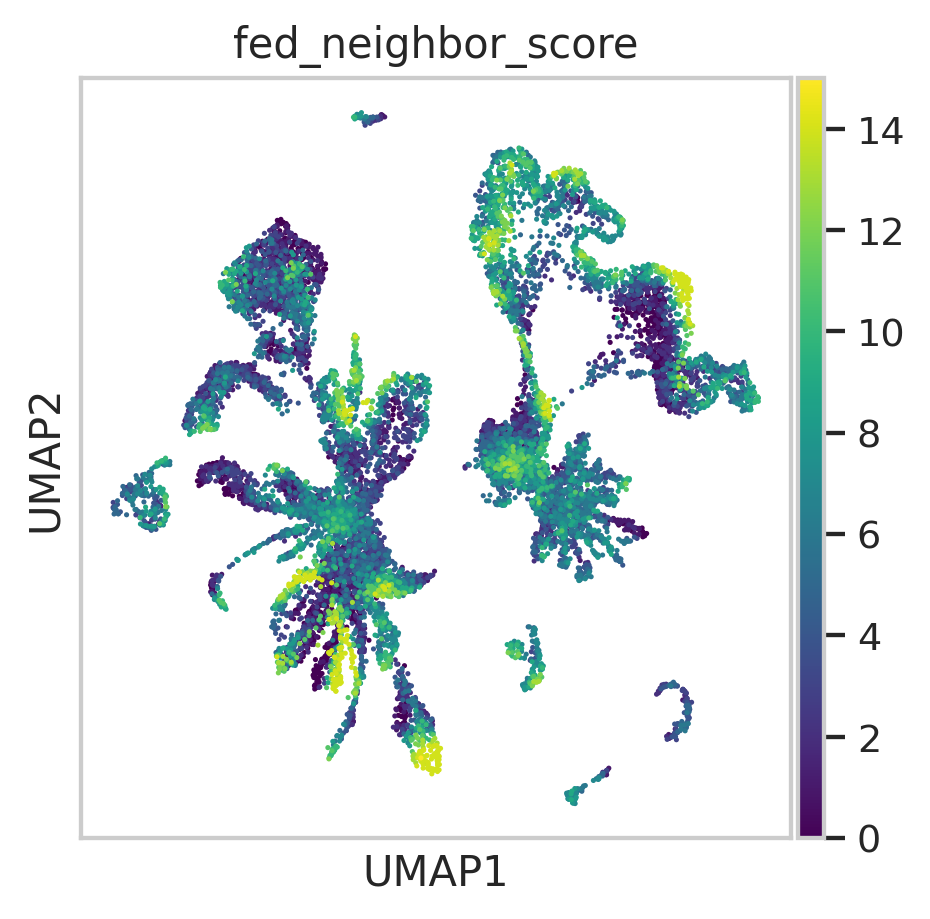

In [30]:
#Plot clusters
bus_fs_raw.obs['fed_neighbor_score'] = neighborScores(bus_fs_raw,True)
sc.pl.umap(bus_fs_raw,color='fed_neighbor_score',color_map='viridis')
sc.pl.tsne(bus_fs_raw,color='fed_neighbor_score',color_map='viridis')
sc.pl.umap(cellRanger_fs,color='fed_neighbor_score',color_map='viridis')

DE Genes in Clusters of Interest

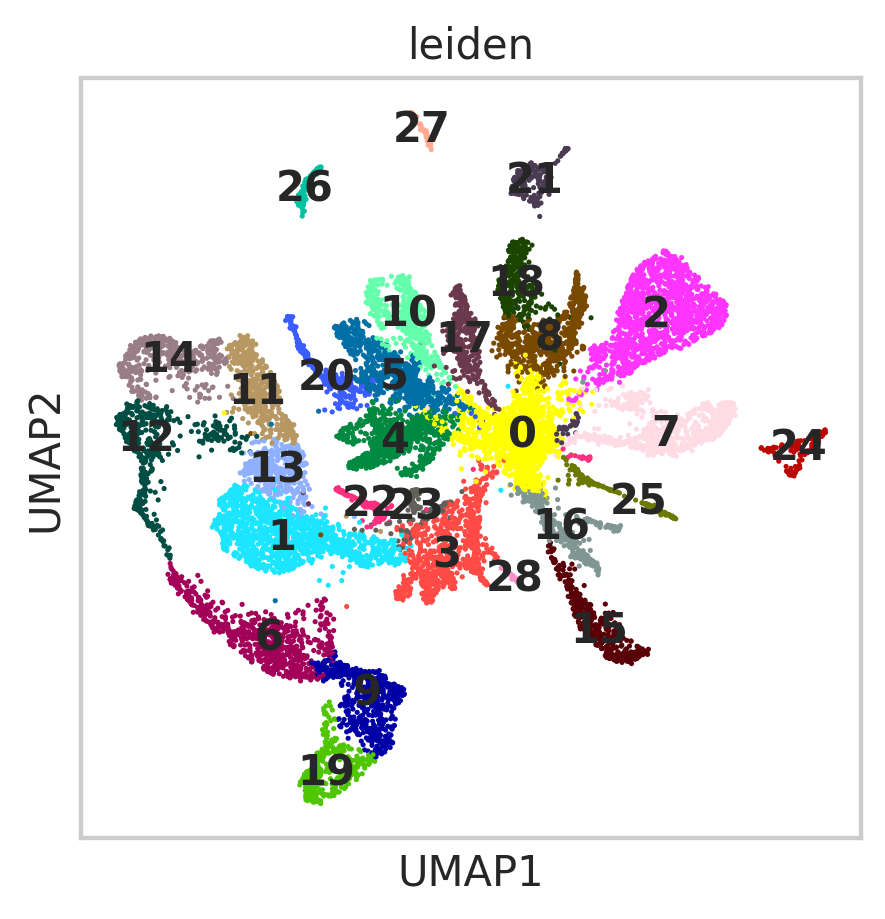

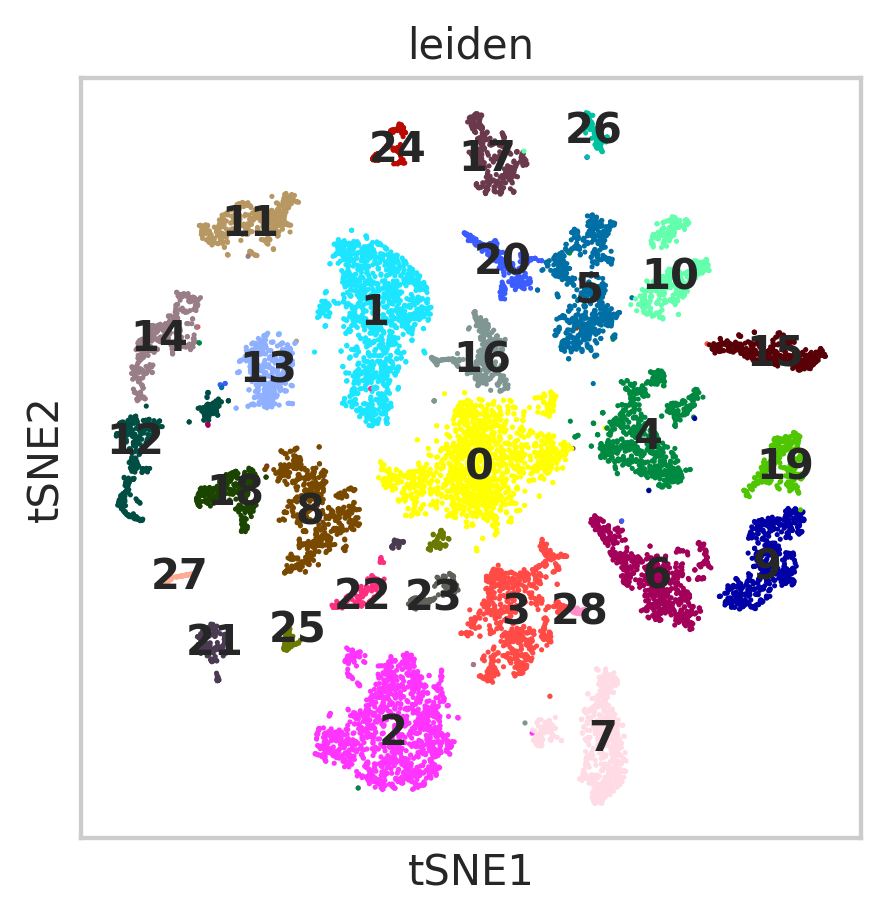

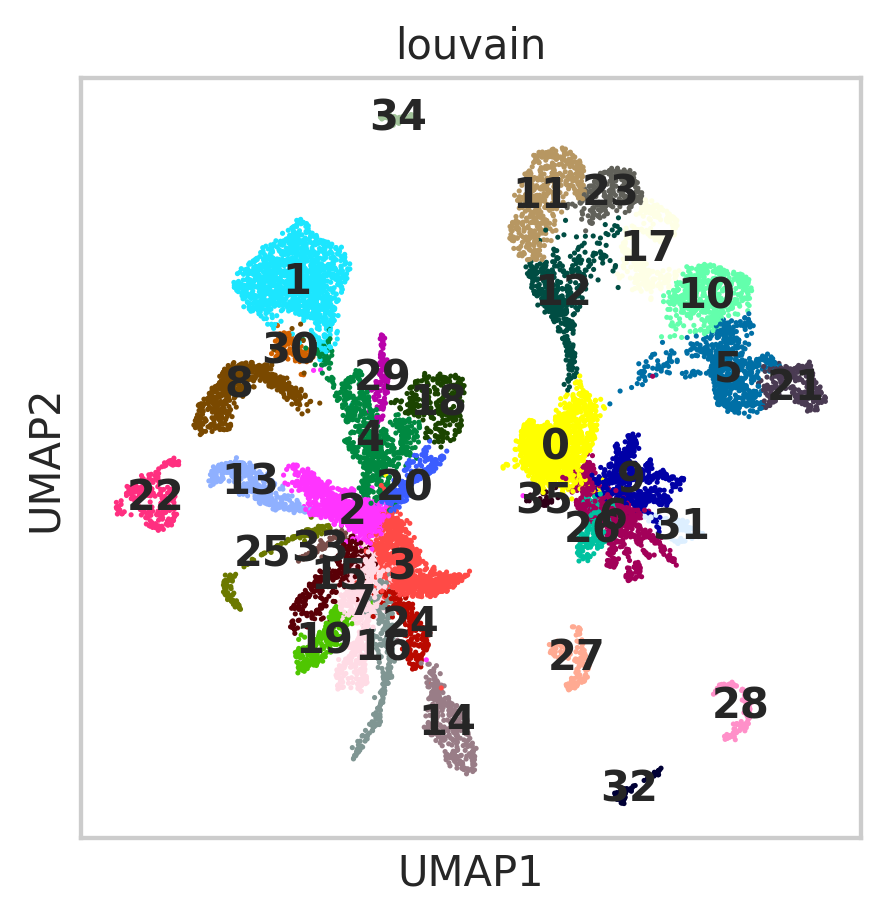

In [32]:
#Plot clusters
sc.pl.umap(bus_fs_raw,color='leiden',color_map='viridis',legend_loc='on data')
sc.pl.tsne(bus_fs_raw,color='leiden',color_map='viridis',legend_loc='on data')
sc.pl.umap(cellRanger_fs,color='louvain',color_map='viridis',legend_loc='on data')

In [0]:
#Examples of genes for clusters of interest


In [0]:
#How to use Rank_genes_groups between conditions to obtain top DE Genes in cluster

####**Overlap with Original CellRanger Clusters** 

In [0]:
#Calculate jaccard score between clusters
def jaccard_calc(orig,new_bus,clust1='leiden',clust2='leiden'):

    orig_clusters = np.unique(orig.obs[clust1])
    bus_clusters = np.unique(new_bus.obs[clust2])

    clusterScores_bus = pd.DataFrame(index=bus_clusters, columns=orig_clusters)

    for i in orig_clusters:
        #Get cell barcodes in each cluster
        sub =  orig[orig.obs[clust1].isin([i])]
        sub_cells =  list(sub.obs_names)
        scores = []

        for j in bus_clusters:
            #Get cell barcodes in each cluster
            bus_sub =  new_bus[new_bus.obs[clust2].isin([j])]
            bus_sub_cells =  list(bus_sub.obs_names)

            #Jaccard score calculation
            union = set(sub_cells).union(bus_sub_cells)
            intersect = set(sub_cells).intersection(bus_sub_cells)
            scores.append(len(intersect)/len(union))


        clusterScores_bus[i] = scores
    
    return clusterScores_bus

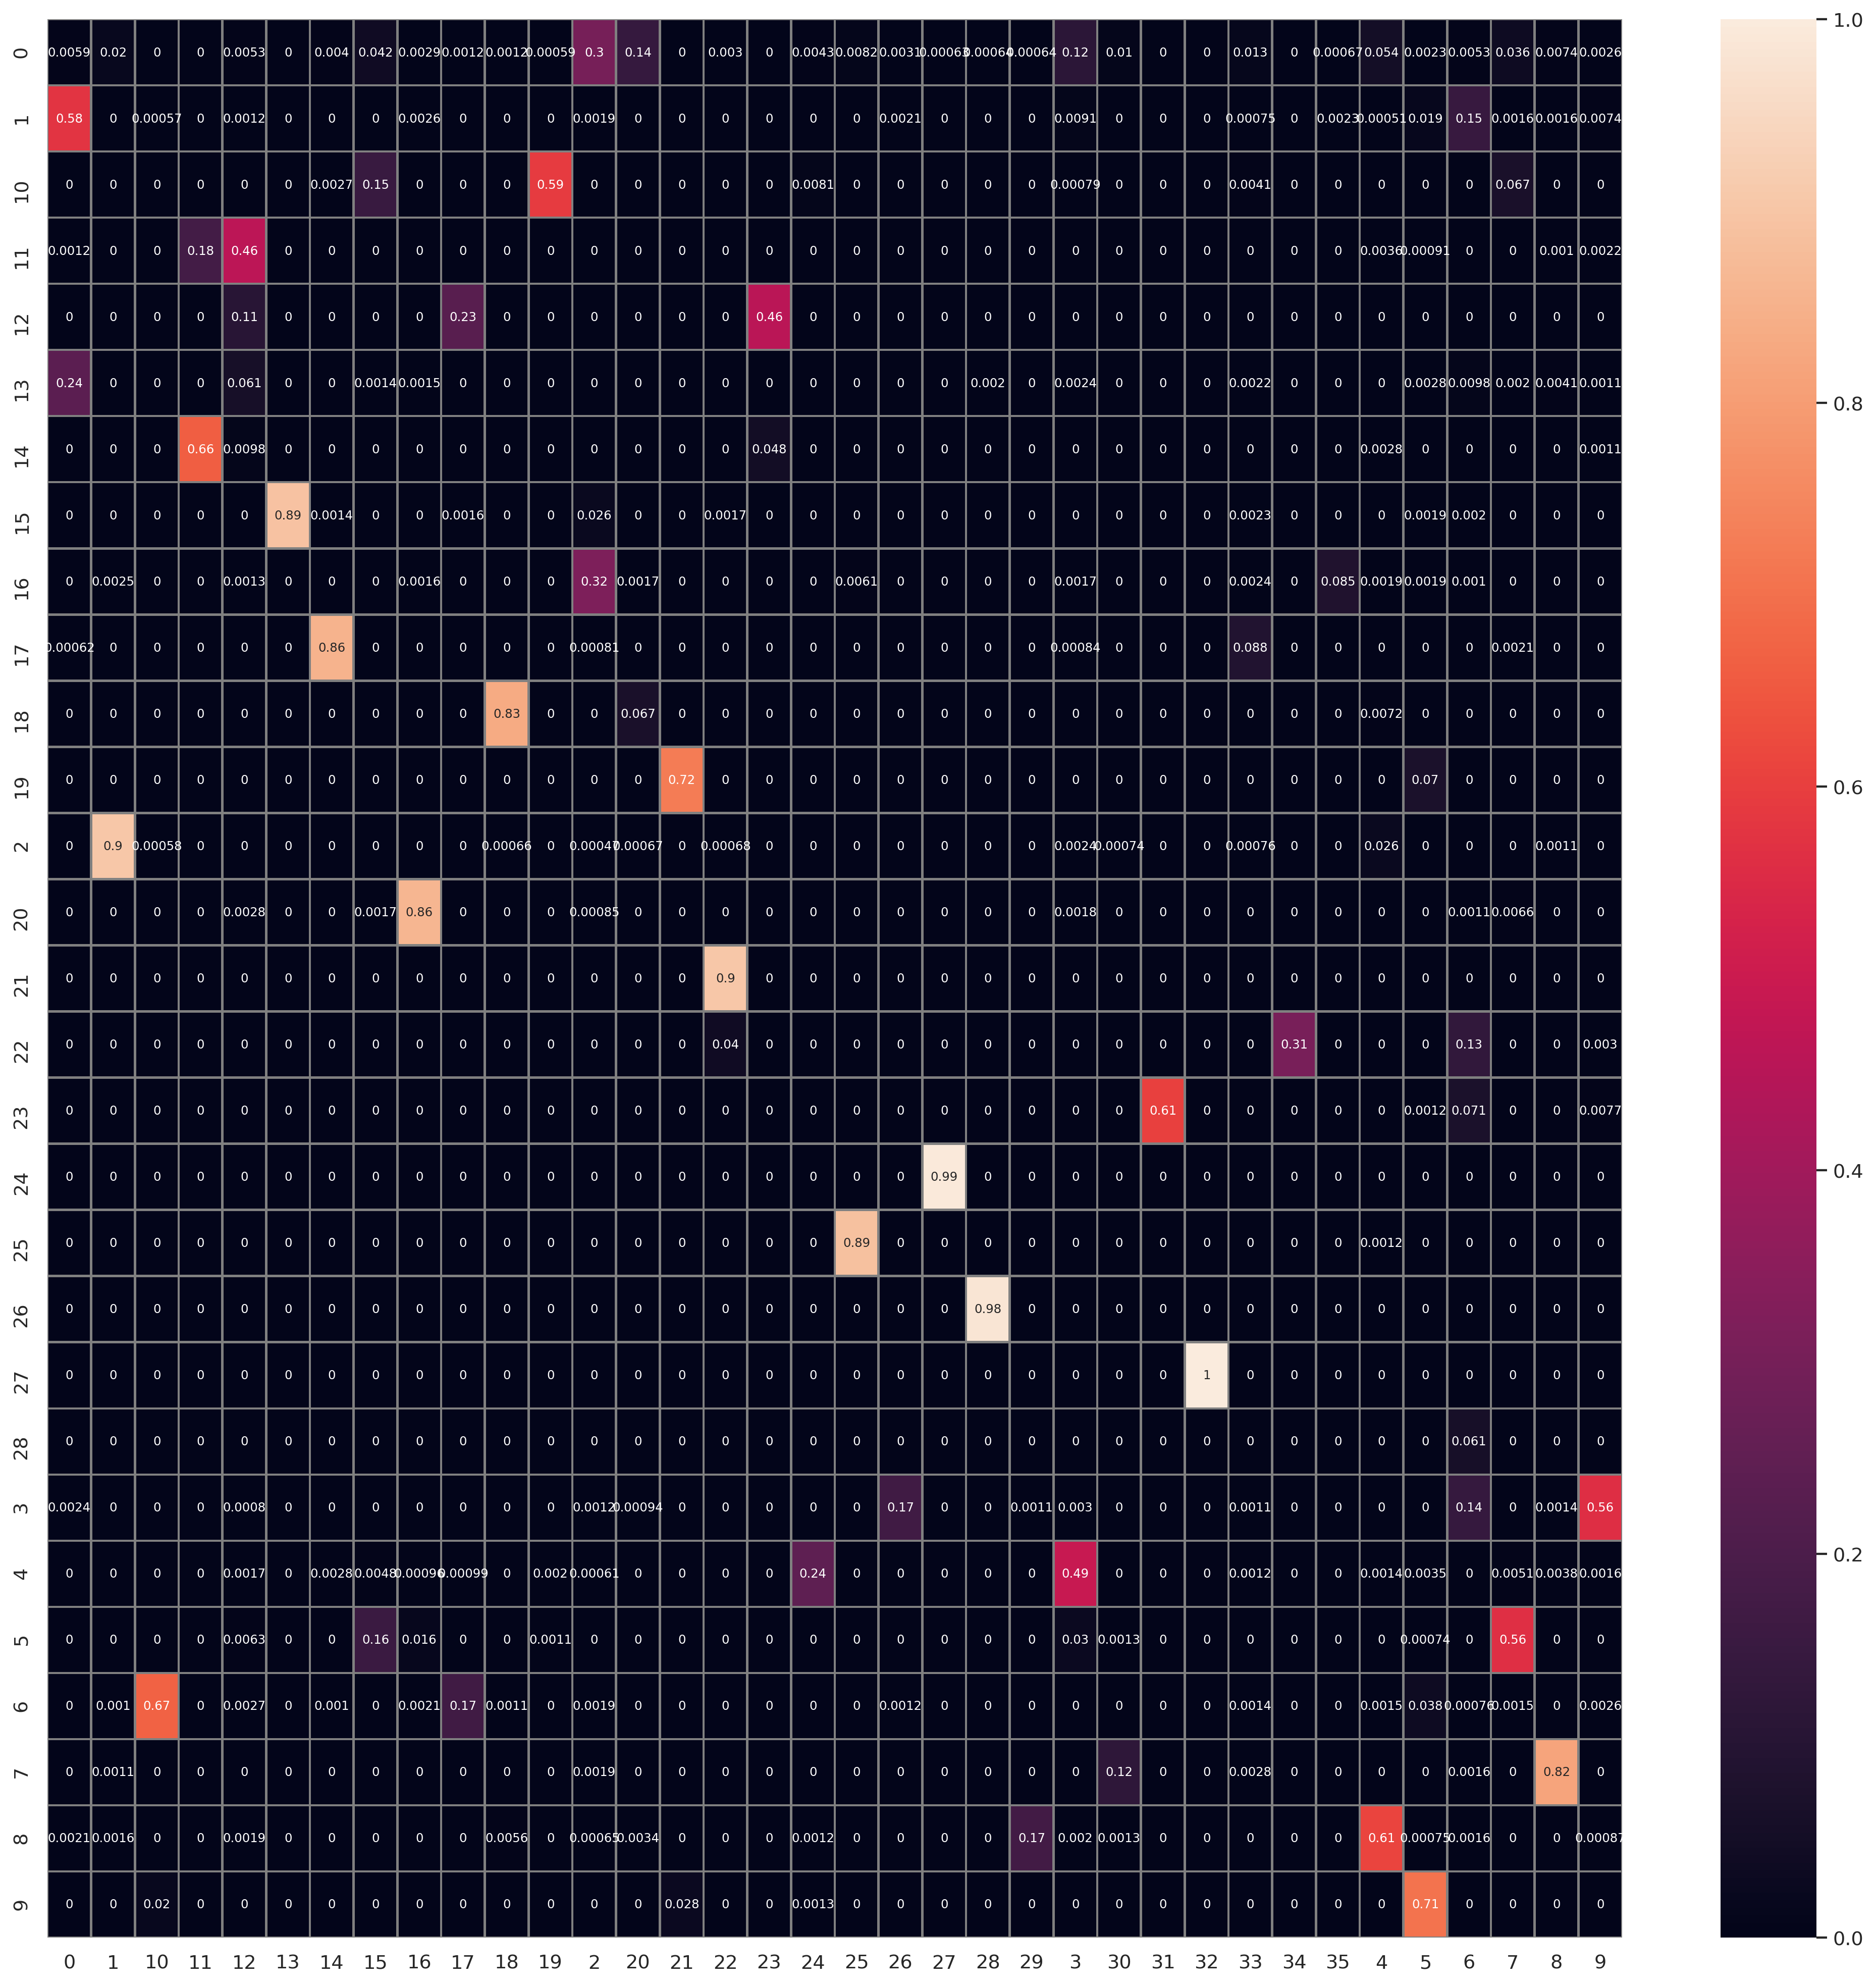

In [34]:
#Plot cluster mapping
clusterScores_bus = jaccard_calc(cellRanger_fs,bus_fs_raw,'louvain','leiden')

plt.figure(figsize=(20,20))
sns.heatmap(clusterScores_bus,annot=True, annot_kws={"size": 7},linewidths=1, linecolor='grey')
plt.show()

In [35]:
#Map cellranger clusters onto new cluster embedding
bus_fs_raw.obs['cellranger_louvain'] = cellRanger_fs.obs['louvain'].loc[list(bus_fs_raw.obs_names)]
bus_fs_raw

AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellranger_louvain'
    var: 'n_counts', 'mean', 'std'
    uns: 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

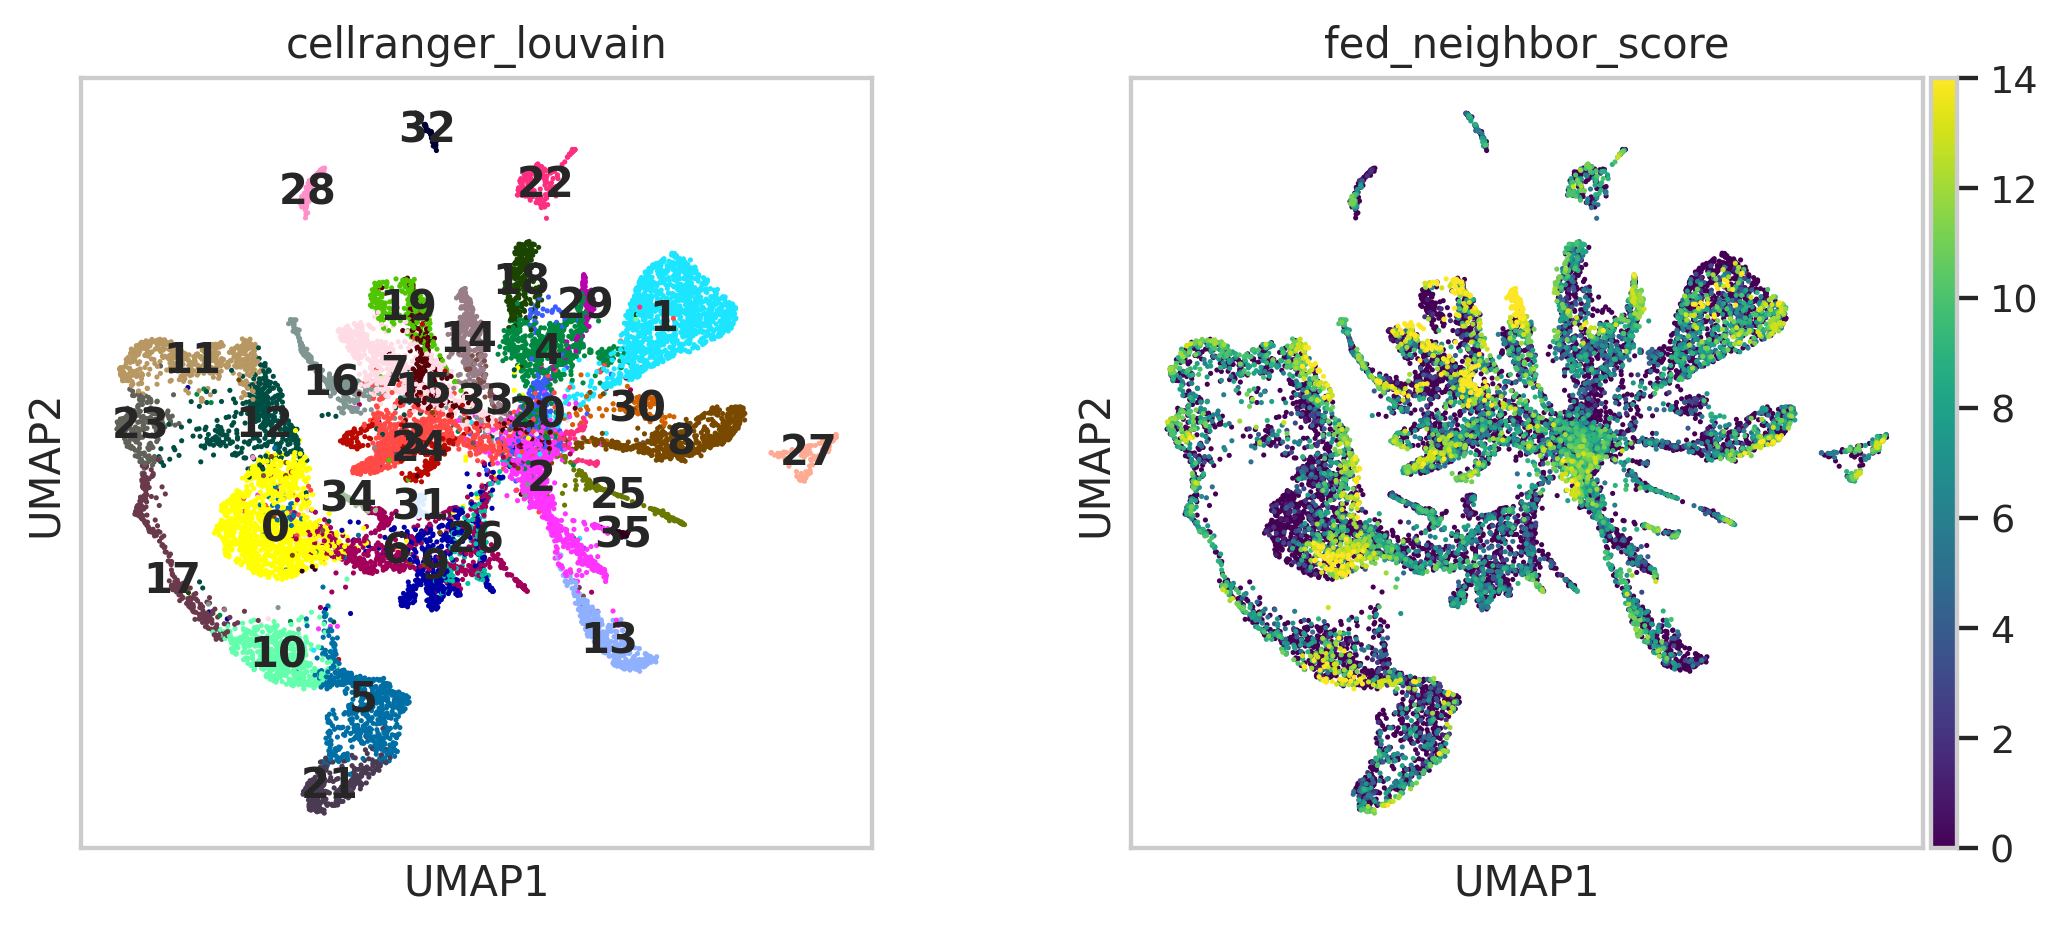

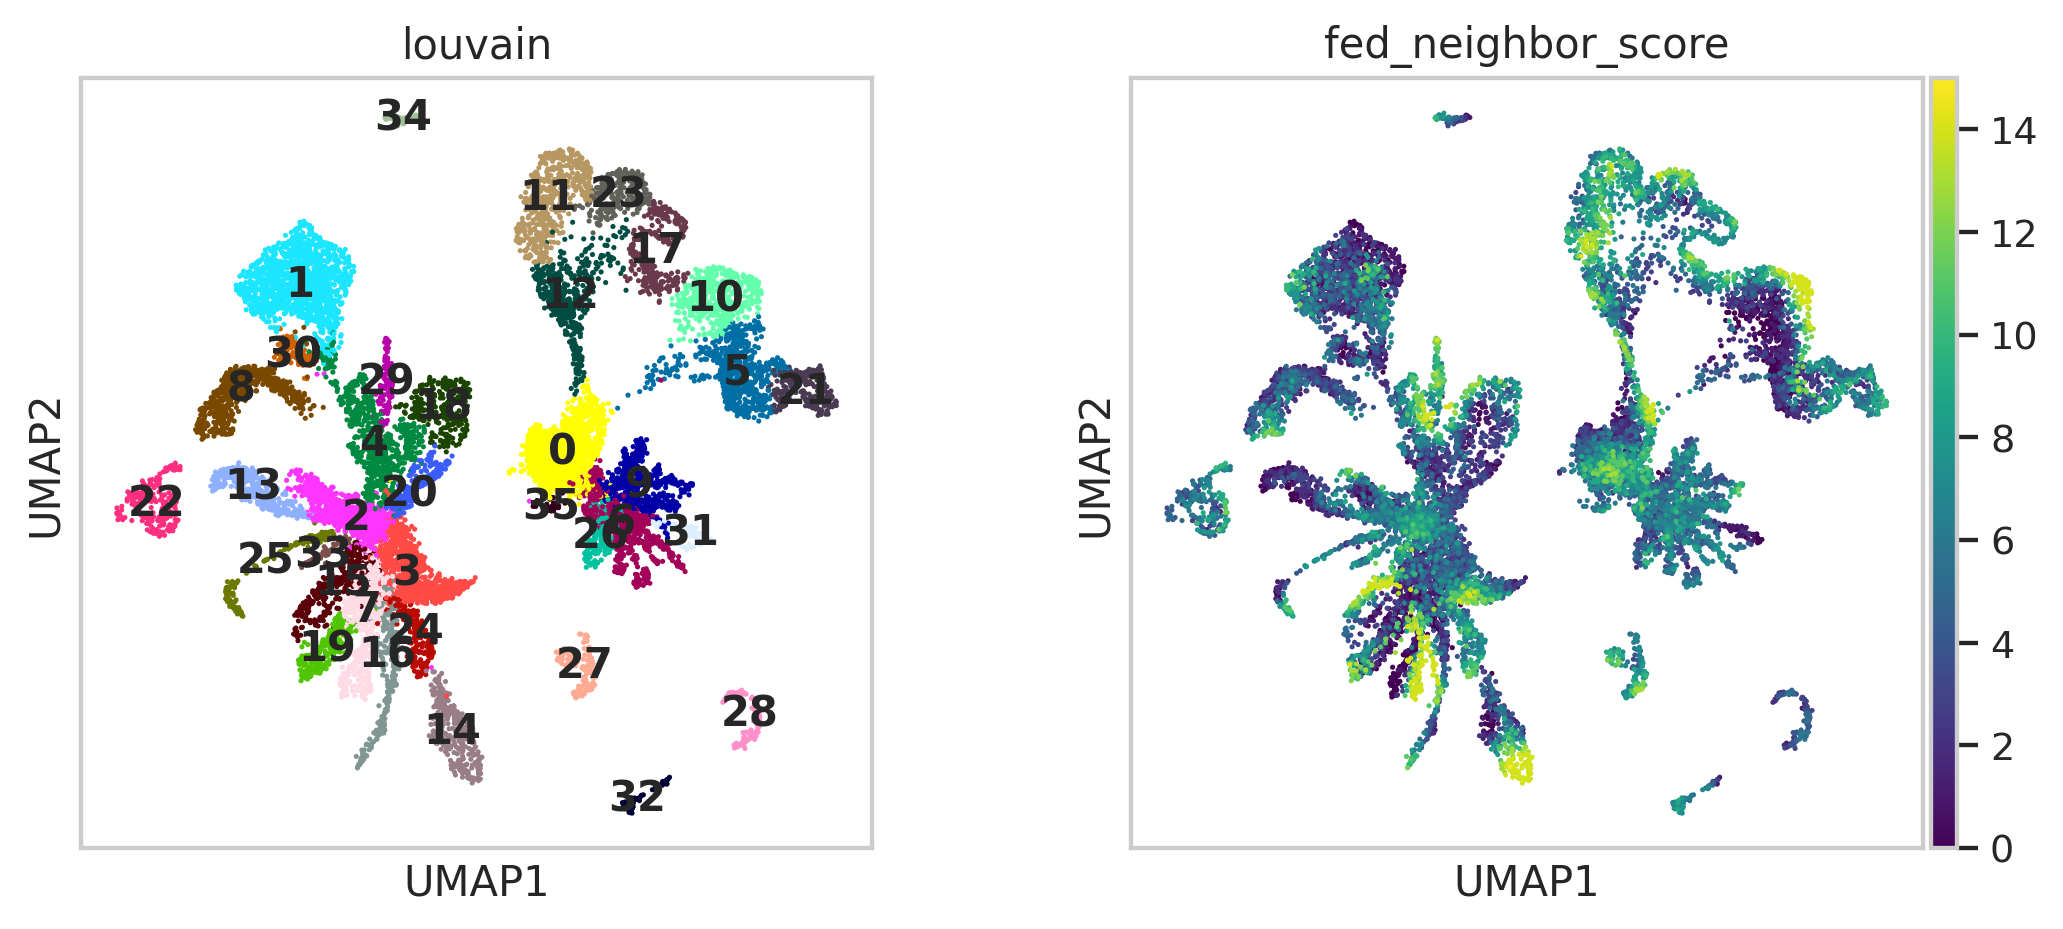

In [36]:
#Plot embedding mappings
sc.pl.umap(bus_fs_raw,color=['cellranger_louvain','fed_neighbor_score'],legend_loc='on data',color_map='viridis')
sc.pl.umap(cellRanger_fs,color=['louvain','fed_neighbor_score'],legend_loc='on data',color_map='viridis')